In [7]:
import snap

In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE

In [10]:
import gensim
import random
import networkx as nx

In [5]:
from sklearn.cluster import KMeans

In [4]:
FIn = snap.TFIn("subGraph.graph")
G = snap.TNGraph.Load(FIn)
del FIn

In [5]:
PageRank=G.GetPageRank()

In [51]:
def genWalkst(G,s,t,k,reverse=False):
    cur=s
    ret=[]
    while cur!=t and k>=0:
        ret.append(cur)
        if reverse:
            next=[i for i in G.GetNI(int(cur)).GetInEdges()]
        else:    
            next=[i for i in G.GetNI(int(cur)).GetOutEdges()]
        cur=np.random.choice(next)
        k-=1
    if reverse:
        ret.reverse()
    return ret

In [8]:
def genWalk(G,s,k,p,q):
    cur=s
    ret=[]
    # first pace
    ret.append(cur)    
    next=[i for i in G.GetNI(int(cur)).GetOutEdges()]+[i for i in G.GetNI(int(cur)).GetInEdges()]
    if len(next)==0:
            return ret
    prob=np.array([1.0 for i in next])
    prob/=np.sum(prob)
    prev=cur
    cur=np.random.choice(next,p=prob)
    ret.append(cur) 
    k-=1
    while k>=0:  
        next=[i for i in G.GetNI(int(cur)).GetOutEdges()]+[i for i in G.GetNI(int(cur)).GetInEdges()]
        if len(next)==0:
            break
        prob=np.array([p if i==prev else q if G.IsEdge(int(i),int(prev)) or G.IsEdge(int(prev),int(i)) else 1 for i in next])
        prob/=sum(prob)
        prev=cur
        cur=np.random.choice(next,p=prob)
        k-=1
        ret.append(cur) 
    return ret

In [ ]:
G.IsEdge

In [51]:
genWalk(G,2,10,1.0,2.0)

[2, 155019, 198866, 155019, 198866, 155019, 2, 59149, 2, 135, 13832, 135]

In [52]:
s=2
t=2000
k=5

In [52]:
set=[genWalkst(G,s,t,k+2) for i in range(500)]+[genWalkst(G,t,s,k+2,reverse=True) for i in range(500)]

In [63]:
node=[i.GetId() for i in G.Nodes()]
prob=[PageRank[i] for i in node]
set=[genWalk(G,np.random.choice(node,p=prob),5,1.0,2.0) for i in range(1000)]
set=[[str(j) for j in i]for i in set]

In [64]:
model=gensim.models.Word2Vec(set,size=10, window=5)

In [79]:
def visualizeEmbedding(model):
    tsne=TSNE(n_components=2)
    emb=np.array([model[i] for i in model.wv.vocab])
    vis=tsne.fit_transform(emb)
    plt.scatter(vis[:,0],vis[:,1])

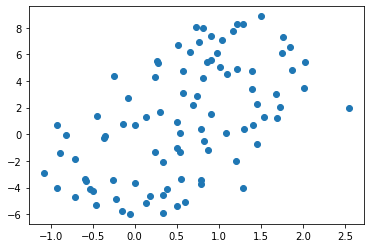

In [80]:
visualizeEmbedding(model)

In [93]:
node_sel=[i for i in model.wv.vocab]
emb=np.array([model[i] for i in node_sel])

In [102]:
km=KMeans(n_clusters=9)

In [103]:
km.fit(emb)

KMeans(n_clusters=9)

In [104]:
div=km.predict(emb)

In [105]:
div

array([1, 4, 2, 1, 1, 2, 7, 6, 6, 4, 7, 6, 7, 6, 2, 2, 4, 2, 2, 2, 1, 2,
       3, 2, 5, 7, 2, 1, 7, 2, 6, 4, 2, 2, 2, 6, 7, 1, 7, 5, 6, 4, 0, 0,
       7, 7, 8, 7, 6, 2, 2, 1, 2, 2, 1, 0, 0, 2, 1, 5, 5, 1, 2, 6, 2, 8,
       7, 7, 7, 8, 4, 4, 2, 4, 6, 4, 4, 4, 2, 7, 2, 8, 0, 6, 5, 4, 0, 0,
       7, 2, 8], dtype=int32)

In [106]:
import networkx as nx
subG=nx.DiGraph()
subG.add_edges_from([(i.GetSrcNId(),i.GetDstNId()) for i in G.Edges()])
layout=nx.drawing.layout.kamada_kawai_layout(subG)

In [26]:
def drawNodeColor(G,nodelist,nodecolor,layout):
    nx.draw(G,pos=layout,nodelist=nodelist,node_color=nodecolor,width=10)

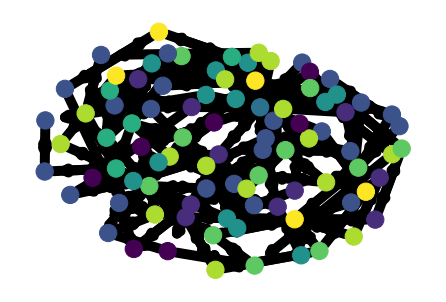

In [107]:
drawNodeColor(subG,[int(i) for i in node_sel],div,layout)

In [117]:
node2color={int(node):div[i] for i,node in enumerate(node_sel)}

In [124]:
c={i for i in div}

In [127]:
colorpre={}
for i in c:
    colornode=[j for j in node2color if node2color[j]==i]
    nodeval=[PageRank[j] for j in colornode]
    colorpre[i]=colornode[np.argmax(nodeval)]

In [128]:
newsubG=nx.DiGraph()
for edge in G.Edges():
    src=colorpre[node2color[edge.GetSrcNId()]]
    dst=colorpre[node2color[edge.GetDstNId()]]
    newsubG.add_edge(src,dst)

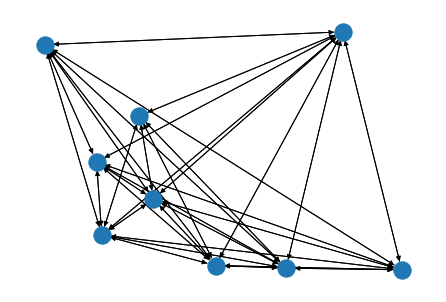

In [129]:
nx.draw(newsubG,layout)

sample

In [11]:
samG=nx.DiGraph()

In [12]:
samG.add_edges_from([[1,i] for i in range(2,5)]+[[i,6] for i in range(2,5)]+[[6,i] for i in range(7,20)]+[[i,21] for i in range(7,20)])

In [14]:
layout_sam=nx.drawing.layout.kamada_kawai_layout(samG)

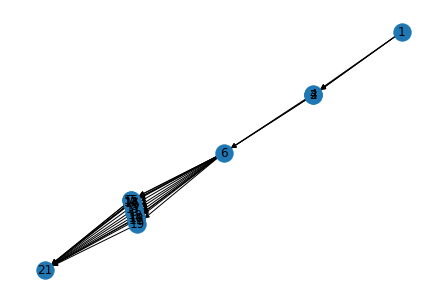

In [15]:
nx.draw(samG,with_labels=True,pos=layout_sam)

In [17]:
sam=snap.TNGraph().New()
for i in samG:
    sam.AddNode(i)
for i in samG:
    for j in samG[i]:
        sam.AddEdge(i,j)

In [45]:
node=[i.GetId() for i in sam.Nodes()]
sam_pr=sam.GetPageRank()
rw=[genWalk(sam,np.random.choice(node),7,1.0,1.0) for i in range(100)]
rw=[[str(j) for j in i]for i in rw]

In [48]:
model=gensim.models.Word2Vec(rw,size=3, window=5)
emb=np.array([model[str(i)] for i in node])

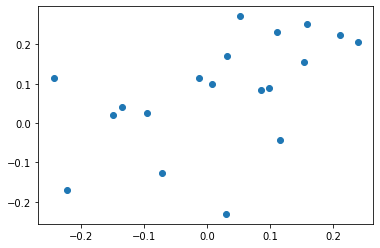

In [47]:
plt.scatter(emb[:,0],emb[:,1])

In [50]:
km_sam=KMeans(n_clusters=3)
km_sam.fit(emb)
pred=km_sam.predict(emb)

KMeans(n_clusters=5)

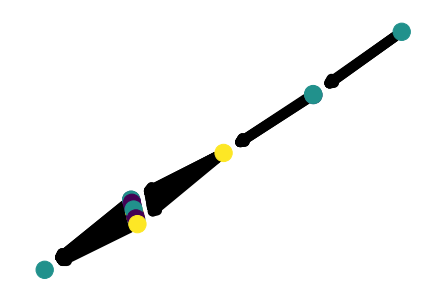

In [51]:
drawNodeColor(samG,node,pred,layout_sam)